In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.ndimage import gaussian_filter
from scipy.signal import find_peaks
import pandas as pd
import histlite as hl
plt.rcParams['figure.figsize'] = [10, 10]
plt.rcParams.update({'font.size': 18}) 
import cycler
import sys
sys.path.append('/dybfs2/nEXO/fuys/stanford_teststand/')
from TMSAnalysis.StruckAnalysisConfiguration import StruckAnalysisConfiguration
import os
import time
color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [2]:
analysis_config = StruckAnalysisConfiguration.StruckAnalysisConfiguration()
analysis_config.GetChannelMapFromFile('/dybfs2/nEXO/fuys/stanford_teststand/TMSAnalysis/config/30th/Channel_Map_Run30.csv')
analysis_config.GetRunParametersFromFile('/dybfs2/nEXO/fuys/stanford_teststand/TMSAnalysis/config/30th/Run_Parameters_Run30_20200911_OvernightBi207_AfterFilling.csv')
analysis_config.GetCalibrationConstantsFromFile('/dybfs2/nEXO/fuys/stanford_teststand/TMSAnalysis/config/30th/Calibrations_Xe_Run11b.csv')

### reading HDF5 filelist

In [3]:
filepath = '/dybfs2/nEXO/fuys/stanford_teststand/data/30th/20200912_MorningNoise_PreRecirculation/Cali_data/data/'
files = os.listdir(filepath)
Run_message = filepath.split('/')[6:8]
dflist = []
file_count =0 
for filename in files:
    if file_count%10==0:
        print(file_count)
    if file_count > 49:
        break
    file_count +=1
    if '0912' in filename and filename.endswith('.h5'): 
        dflist.append(pd.read_hdf('/dybfs2/nEXO/fuys/stanford_teststand/data/30th/20200912_MorningNoise_PreRecirculation/Cali_data/data/'+filename))
        
df05 = pd.concat(dflist,ignore_index=True)


0


### display raw data waveform

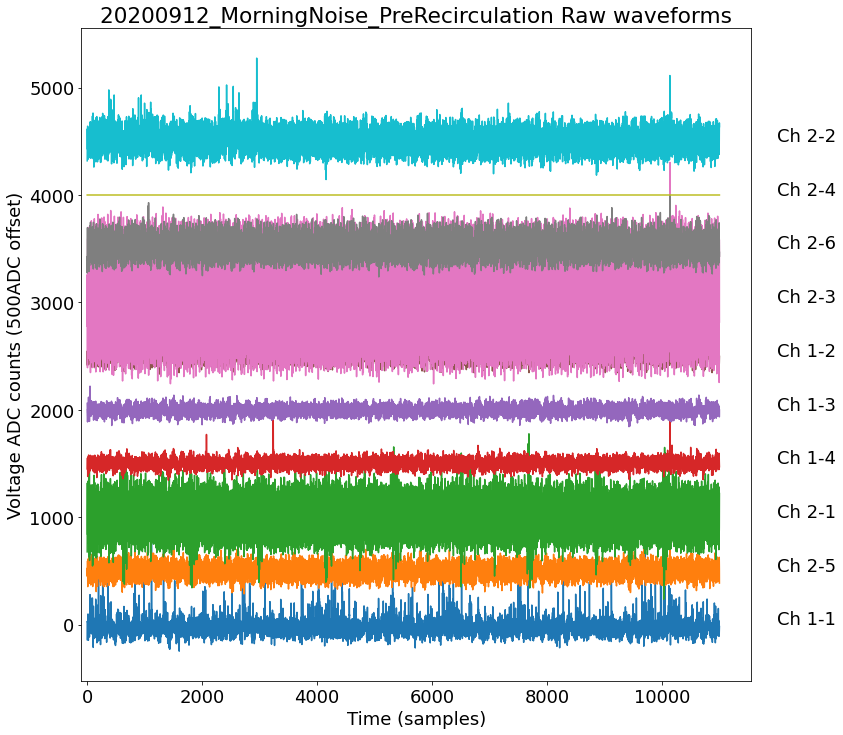

In [4]:
evt_num = 3
evt = df05.iloc[evt_num]
plt.rcParams['figure.figsize'] = [12,12]
plt.rcParams.update({'font.size': 18})

chlabels = []
yvalues = []
num_channels = 0

for i in range(len(evt['Channels'])):
    if 'SiPM' not in evt['ChannelTypes'][i]:
        continue
    else:
        num_channels += 1
    ch_name = analysis_config.GetChannelNameForSoftwareChannel(evt['Channels'][i])
    chlabels.append(ch_name)
    yvalues.append((num_channels-1)*500.)
    baseline = np.mean(evt['Data'][i][0:200]) 
    
    plt.plot(evt['Data'][i]-baseline + yvalues[num_channels-1])#,\label='Ch {}'.format(ch_name),color=color_cycle[num_channels-1])
    plt.text(12000,yvalues[num_channels-1],'Ch {}'.format(ch_name))

plt.xlim(-100)    
#plt.legend(fontsize=18,loc='upper right',handlelength=0.75)
plt.xlabel('Time (samples)')
plt.ylabel('Voltage ADC counts (500ADC offset)')
plt.title('{} Raw waveforms'.format(Run_message[1]))
plt.savefig('./plots/{}_{}_Raw_data.png'.format(Run_message[0],Run_message[1]))


### display waveforms after process

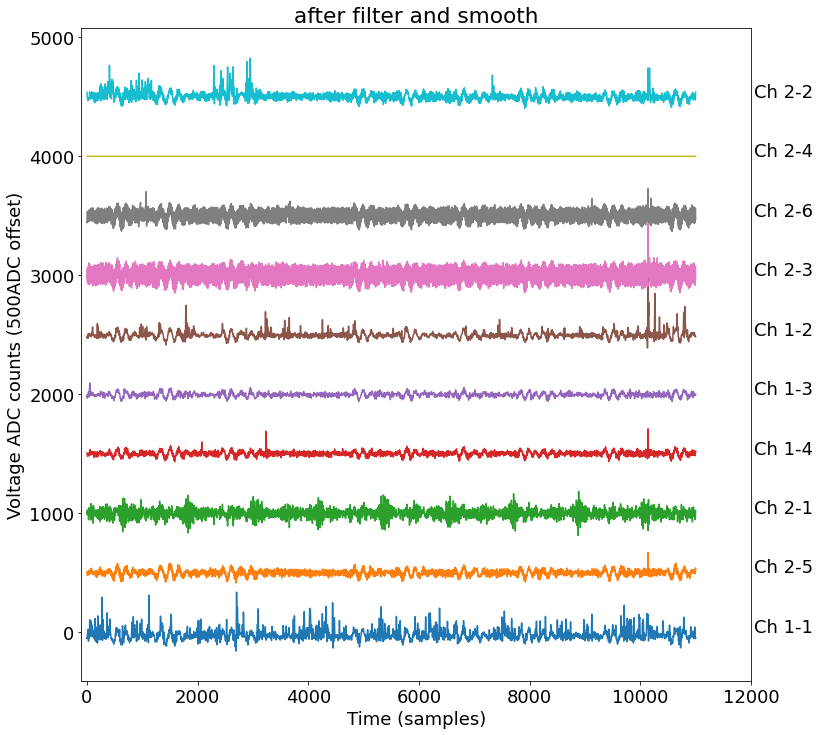

In [5]:
plt.close()
from scipy.signal import butter
from scipy.signal import filtfilt
import scipy.optimize as opt
plt.rcParams['figure.figsize'] = [12,12]
plt.rcParams.update({'font.size': 18})

evt = df05.iloc[evt_num]
chlabels = []
yvalues = []
num_channels = 0

for i in range(len(evt['Channels'])):
    if 'SiPM' not in evt['ChannelTypes'][i]:
        continue
    else:
        num_channels += 1   
    
    ch_name = analysis_config.GetChannelNameForSoftwareChannel(evt['Channels'][i])
    
    chlabels.append(ch_name)
    yvalues.append((num_channels-1)*500.)
    
    baseline = np.mean(evt['Data'][i][0:200])   
    raw_data = evt['Data'][i]-baseline  
    nyq = 0.5 * 1./len(raw_data)  
    
    #process method
    sampling_period_ns = 1./(62.5/1.e3)#hard code need to change
    
    wfm_fft =np.fft.rfft(raw_data)					
    #FFT and high frequence cut(<0.5e7)
    wfm_fft_pass = np.zeros_like(wfm_fft) 
    freqs = np.fft.rfftfreq(len(raw_data),d=1.e-9*sampling_period_ns)
    fft_freq_pass = np.logical_and(freqs < 0.5e7, freqs >=0)
    wfm_fft_pass[fft_freq_pass] = wfm_fft[fft_freq_pass]	
    #inverse FFT
    wfm_ifft_pass = np.fft.irfft(wfm_fft_pass)
    
    plt.plot(wfm_ifft_pass + yvalues[num_channels-1])#,label='Ch {}'.format(ch_name),color=color_cycle[num_channels-1])
    plt.text(12050,yvalues[num_channels-1],'Ch {}'.format(ch_name))
plt.xlim(-100.,12000.)
#plt.legend(fontsize=18,loc='upper right',handlelength=0.75)
plt.xlabel('Time (samples)')
plt.ylabel('Voltage ADC counts (500ADC offset)')
plt.title('after filter and smooth')
plt.savefig('./plots/{}_{}_after_process.png'.format(Run_message[0],Run_message[1]))


### process data, include butter filter and smooth 

In [6]:
adc_vals = dict()
for label in chlabels:
    adc_vals[label] = []
    
for index, evt in df05.iterrows():
    if index % 100 == 0:
        print('Running event {}'.format(index))
    for i in range(len(evt['Channels'])):
        if 'SiPM' not in evt['ChannelTypes'][i]:
            continue
        else:
            num_channels += 1
        row = (num_channels-1) % 3
        col = int(np.floor( (num_channels-1)/3. ))

        ch_name = analysis_config.GetChannelNameForSoftwareChannel(evt['Channels'][i])
        baseline = np.mean(evt['Data'][i][0:200])
        raw_data = evt['Data'][i]-baseline        
        
        wfm_fft =np.fft.rfft(raw_data)					
        #FFT and high frequence cut(<0.5e7)
        wfm_fft_pass = np.zeros_like(wfm_fft) 
        freqs = np.fft.rfftfreq(len(raw_data),d=1.e-9*sampling_period_ns)
        fft_freq_pass = np.logical_and(freqs < 0.5e7, freqs >=0)
        wfm_fft_pass[fft_freq_pass] = wfm_fft[fft_freq_pass]	
        #inverse FFT
        wfm_ifft_pass = np.fft.irfft(wfm_fft_pass)
        adc_vals[ch_name].extend( list(wfm_ifft_pass) )
        
for channel, data in adc_vals.items():
    adc_vals[channel] = np.array(data)


Running event 0
Running event 100
Running event 200


### fix sigma value for find peak algorithm(use smoothed data)

Channel 1-1: 1sigma = 30.81
Channel 2-5: 1sigma = 20.88
Channel 1-4: 1sigma = 17.07
Channel 1-3: 1sigma = 15.63
Channel 1-2: 1sigma = 19.3
Channel 2-6: 1sigma = 58.88
Channel 2-2: 1sigma = 26.69


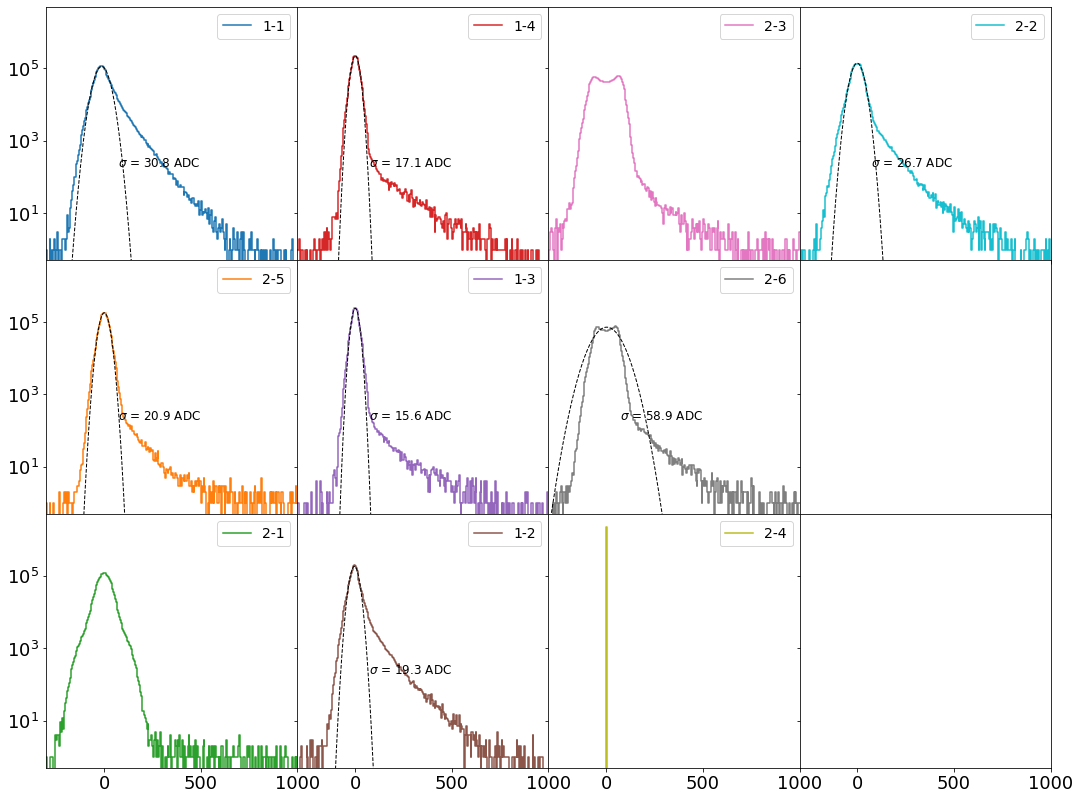

In [9]:
plt.close()
plt.rcParams['figure.figsize'] = [18,14]
plt.rcParams.update({'font.size': 18})
fig, ax = plt.subplots(ncols=4,nrows=3,sharex=True,sharey=True,gridspec_kw={'hspace':0.,'wspace':0.})

def Gaussian(x,A,mu,sig):
    return A*np.exp(-(x-mu)**2/(2*sig**2))

sigmas_smoothed = dict()
index = 0
for channel, array in adc_vals.items():

    row = (index) % 3
    col = int(np.floor( index/3. ))
    
    thishist = hl.hist( array, bins=np.linspace(-300.,1000.,301) )
    hl.plot1d( ax[row,col], thishist, color=color_cycle[index],label=channel )
    
    ax[row,col].legend(fontsize=14)
    ax[row,col].set_yscale('log')
    ax[row,col].set_ylim(0.5,5000000.)
    ax[row,col].set_xlim(-300.,1000.)
    
    bin_centers = (thishist.bins[0][1:] + thishist.bins[0][:-1])/2.
    bin_vals = thishist.values
    fitmask = (bin_centers>-100.)&(bin_centers<100.)

    if '2-1'  not in channel and '2-3' not in channel and '2-4' not in channel:
        p,pcov = opt.curve_fit(Gaussian,bin_centers[fitmask],bin_vals[fitmask],p0=(5000000.,0.,10.))
        sigmas_smoothed[channel] = p[2]
        print('Channel {}: 1sigma = {:4.4}'.format(channel,p[2]))
        textstring = r'$\sigma$ = {:3.3} ADC'.format(p[2])
        ax[row,col].text(70.,200.,textstring,fontsize=12)

        xfit = np.linspace(-300.,300.,200)
        yfit = Gaussian(xfit,p[0],p[1],p[2])
        ax[row,col].plot(xfit,yfit,'--k',linewidth=1)
    
    index += 1

plt.savefig('./plots/{}_{}_histogram_of_sigma.png'.format(Run_message[0],Run_message[1]))


### define PulseFinder function to process data

In [11]:
def PulseFinder( raw_data, chname, threshold_sig=4. ):
    wfm_fft =np.fft.rfft(raw_data)					
    #FFT and high frequence cut(<0.5e7)
    wfm_fft_pass = np.zeros_like(wfm_fft) 
    freqs = np.fft.rfftfreq(len(raw_data),d=1.e-9*sampling_period_ns)
    fft_freq_pass = np.logical_and(freqs < 0.5e7, freqs >=0)
    wfm_fft_pass[fft_freq_pass] = wfm_fft[fft_freq_pass]	
    #inverse FFT
    wfm_ifft_pass = np.fft.irfft(wfm_fft_pass)
    peaks, _= find_peaks(wfm_ifft_pass,height = sigmas_smoothed[chname]*threshold_sig)

    return peaks

### find peak in one event and display

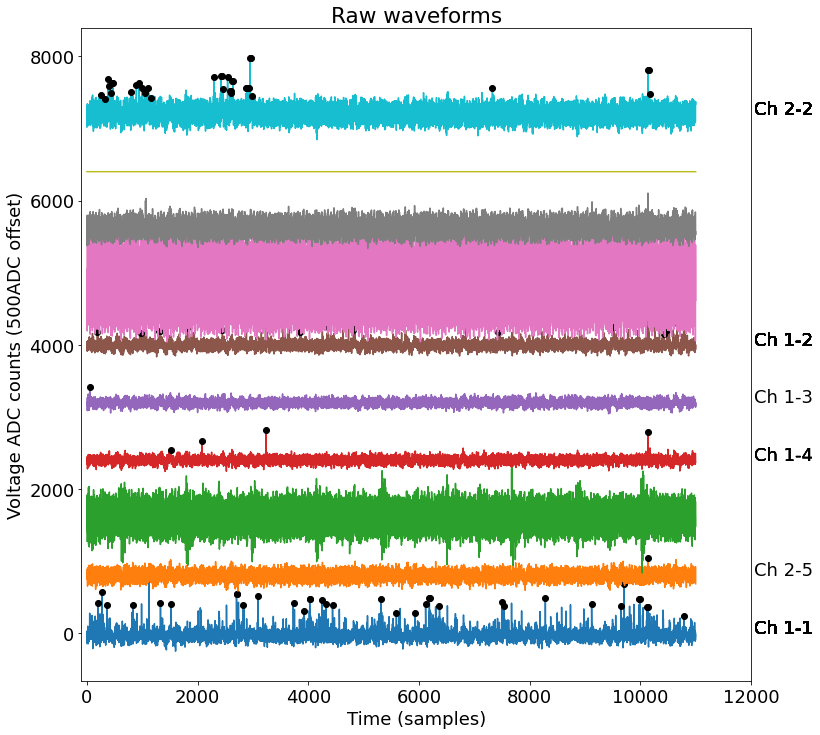

In [17]:
plt.close()
evt_num = 3
evt = df05.iloc[evt_num]

plt.rcParams['figure.figsize'] = [12,12]
plt.rcParams.update({'font.size': 18})

chlabels = []
yvalues = []
num_channels = 0

for i in range(len(evt['Channels'])):
    if 'SiPM' not in evt['ChannelTypes'][i]:
        continue
    else:
        num_channels += 1
    
    
    ch_name = analysis_config.GetChannelNameForSoftwareChannel(evt['Channels'][i])
    
    chlabels.append(ch_name)
    yvalues.append((num_channels-1)*800.)
    
    baseline = np.mean(evt['Data'][i][0:200]) 
    
    raw_data = evt['Data'][i]-baseline
    xvals = np.arange(len(raw_data))    
    plt.plot(xvals, raw_data + yvalues[num_channels-1],\
             label='Ch {}'.format(ch_name),color=color_cycle[num_channels-1])
    
    if '2-1'  not in ch_name and '2-3' not in ch_name and '2-4' not in ch_name:    
    #if '1-1' not in ch_name and '1-3' not in ch_name:
        pulse_idxs = PulseFinder(raw_data,ch_name,threshold_sig=4)
        for idx in pulse_idxs:
            if idx >=20:
                plt.plot(xvals[idx], np.max(raw_data[idx-20:idx+20]) + yvalues[num_channels-1],'ok')
            if idx <20:
                plt.plot(xvals[idx], np.max(raw_data[0:idx+20]) + yvalues[num_channels-1],'ok')
            plt.text(12050,yvalues[num_channels-1],'Ch {}'.format(ch_name))
plt.xlim(-100.,12000.)    
#plt.legend(fontsize=18,loc='upper right',handlelength=0.75)
plt.xlabel('Time (samples)')
plt.ylabel('Voltage ADC counts (500ADC offset)')
plt.title('Raw waveforms')
plt.savefig('./plots/{}_{}_peak_display_one_event.png'.format(Run_message[0],Run_message[1]))

### SiPM gain calibration process 

In [19]:
plt.close()
pulse_heights = dict()

for label in chlabels:
    if '2-1'  not in label and '2-3' not in label and '2-4' not in label:    
        pulse_heights[label] = []

for index, evt in df05.iterrows():
    for i in range(len(evt['Channels'])):
        if 'SiPM' not in evt['ChannelTypes'][i]:
            continue
        ch_name = analysis_config.GetChannelNameForSoftwareChannel(evt['Channels'][i])

        if '2-1'  not in ch_name and '2-3' not in ch_name and '2-4' not in ch_name:    
            baseline = np.mean(evt['Data'][i][0:200]) 
            raw_data = evt['Data'][i]-baseline
            evtpulseidxs = PulseFinder(raw_data,ch_name,threshold_sig=3)
            evtpulseheights = []

            for idx in evtpulseidxs:
                if idx <20:
                    evtpulseheights.append( np.max(raw_data[0:idx+20]) )
                if idx >20:
                    evtpulseheights.append( np.max(raw_data[idx-20:idx+20]) )
            pulse_heights[ch_name].extend( evtpulseheights )

for channel, data in pulse_heights.items():
    pulse_heights[channel] = np.array(data)

### Draw Calibration results and fix it with multigauss function


SPE mean in channel 1-1: 280.0
SPE mean in channel 2-5: 180.0
SPE mean in channel 1-4: 210.0
SPE mean in channel 1-3: 210.0
SPE mean in channel 1-2: 289.2
everything is ok!


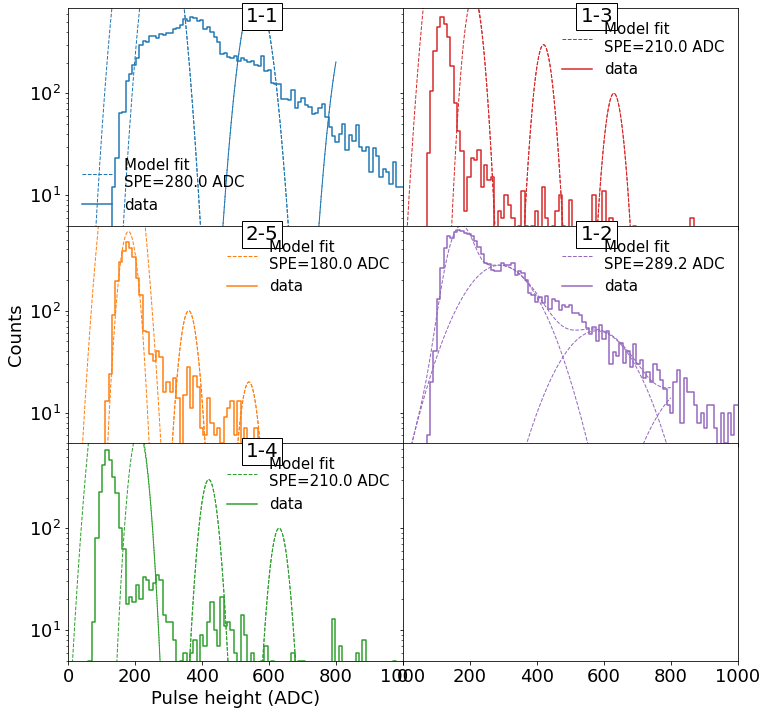

In [20]:
def SPEModel(x, An, mun, sign, Aspe, muspe, sigspe, Adpe, Atpe):
    noise = An * np.exp( -(x-mun)**2/(2*sign**2))
    signal = Aspe * np.exp( -(x-muspe)**2/(2*sigspe**2)) + \
        Adpe * np.exp( -(x-2*muspe)**2/(2*sigspe**2)) + \
        Atpe * np.exp( -(x-3*muspe)**2/(2*sigspe**2))
    return noise + signal

plt.rcParams['figure.figsize'] = [12,12]
plt.rcParams.update({'font.size': 18})
fig, ax = plt.subplots(ncols=2,nrows=3,sharex=True,sharey=True,gridspec_kw={'hspace':0.,'wspace':0.})


pulseheight_hists = dict()
for channel, data in pulse_heights.items():
    pulseheight_hists[channel] = hl.hist(pulse_heights[channel],bins=np.linspace(0.,1000.,100))
i = 0
for channel, hist in pulseheight_hists.items():
    
    row = (i) % 3
    col = int(np.floor( i/3. ))

    bin_centers = (hist.bins[0][1:] + hist.bins[0][0:-1])/2.
    bin_vals = hist.values
    bin_err = np.sqrt(hist.values)
    
    fitmin = 70.
    fitmax = 800.
    munguess = 130
    speguess = 210.
    sigguess = 20.
    aguess = 900.
    adpguess =300.
    atpguess =100.
    if '2-6' in channel or '2-2' in channel:# or '1-1' in channel:
        continue
    if '2-5' in channel:
        fitmin = 70.
        fitmax = 800.
        munguess = 160
        speguess = 180.
        sigguess = 20.
        aguess = 600.
        adpguess =100.
        atpguess =20.
    if '1-1' in channel or '1-2' in channel:
        fitmax=800.
        fitmin=70.
        munguess = 200
        speguess=280.
        sigguess=30.
        aguess =8000.
        adpguess =1000.
        atpguess =500.
    
    fitmask = (bin_centers<fitmax) & (bin_centers > fitmin)
    
    #print('SPE mean in channel {}'.format(channel))
    p,pcov = opt.curve_fit(SPEModel,bin_centers[fitmask],bin_vals[fitmask],sigma=bin_err[fitmask],\
                           #p0=(200.,70.,10.,aguess,speguess,sigguess,200.,50.))
                           p0=(10000.,munguess,30.,aguess,speguess,sigguess,adpguess,atpguess))
    
    print('SPE mean in channel {}: {:4.4}'.format(channel,p[4]))
    hl.plot1d( ax[row,col], hist, color=color_cycle[i], label='data'.format(channel) )
    
    xfit = np.linspace(0.,800.,400)
    yfit = SPEModel(xfit,p[0],p[1],p[2],p[3],p[4],p[5],p[6],p[7])
    ax[row,col].plot(xfit,yfit,'--',color=color_cycle[i],\
                    linewidth=1,label='Model fit\nSPE={:4.4} ADC'.format(p[4]))
    yspe = Gaussian(xfit,p[3],p[4],p[5])
    ydpe = Gaussian(xfit,p[6],2*p[4],p[5])
    ytpe = Gaussian(xfit,p[7],3*p[4],p[5])

    ax[row,col].plot(xfit,yspe,'--',color=color_cycle[i],linewidth=1)
    ax[row,col].plot(xfit,ydpe,'--',color=color_cycle[i],linewidth=1)
    ax[row,col].plot(xfit,ytpe,'--',color=color_cycle[i],linewidth=1)

    ax[row,col].text(530.,500.,'{}'.format(channel),fontsize=20,\
                     bbox={'facecolor':(1.,1.,1.), 'edgecolor':(0.,0.,0.), 'alpha':1.})
    ax[row,col].legend(fontsize=15,edgecolor=(1.,1.,1.),framealpha=0.)
    ax[row,col].set_xlabel('Pulse height (ADC)')
    ax[row,col].set_yscale('log')
    ax[row,col].set_ylim(5.,np.max(bin_vals)*1.1)
    ax[row,col].set_xlim(0.,1000.)
    
    i+=1
ax[1,0].set_ylabel('Counts')
plt.savefig('./plots/{}_{}_1pe_calibration_triggering_channels.png'.format(Run_message[0],Run_message[1]))
print('everything is ok!')
